# MSM Parameter Tuning
In this notebook we compare the performances of MSM, tuning the number of simulations to achieve estimate, and the number of parallel simulation run.

To compare the performance, we compare $|\epsilon - \hat{\epsilon}|$.


In [1]:
import sys
sys.path += ["../src"]
from opinion_dynamics_models_estimation import simulate_BC
import pandas as pd
import opinion_dynamics_models_estimation as oe
from MSM_calibrator import calibrate_params_ABM
from MSM_simulators import FBCM_simulator,PBCM_simulator,NBCM_simulator
import MSM_simulators
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize
import repeat_function
from scipy.special import expit as sigmoid

In [2]:
def complete_calibration(simulator_class, X, edges, evidences, calibration_batches, N, mu, epsilon, rho):
    if simulator_class == FBCM_simulator:
        simulator = simulator_class(X0 = X[0], edges = edges, N = N, mu = mu, real_epsilon = epsilon, rho = rho, seed = None)
        simulator_name = "full_observed"
    elif simulator_class == PBCM_simulator:
        simulator = simulator_class(X0 = X[0], edges = edges, N = N, mu = mu, real_epsilon = epsilon, rho = rho, seed = None)
        simulator_name = "partial_observed"
    elif simulator_class ==  NBCM_simulator:
        simulator = simulator_class(evidences = evidences, edges = edges, N = N, mu = mu, real_epsilon = epsilon, rho = rho, seed = None)
        simulator_name = "noisy_observed"
        
    calibration_df, time_calibration = calibrate_params_ABM(simulator, 
                                                            calibration_batches = calibration_batches)
    
    return {"epsilon_msm": calibration_df["epsilon"][0], "calibration_batches": calibration_batches,
            "real_epsilon": epsilon, "time_calibration": time_calibration, "simulator_name": simulator_name}

    

    

In [4]:
nested_simulations = []
mu = 0.1
rho = 16

for _ in range(30):
    np.random.seed(None)
    epsilon = np.random.random() / 2
    
    nested_simulations += repeat_function.nested_rep([oe.simulate_BC, 
                                                      {"N": 100, "edge_per_t": 16, 
                                                       "evidences_per_t": 8, 
                                                       "parameters": [epsilon, mu, rho]}, 
                                                      {"T": [32, 64, 128],},
                                                      1], 
                                                     ["X", "edges", "evidences"],
                                                     [complete_calibration, 
                                                      {"N": 100,
                                                       "mu":mu,
                                                       "epsilon":epsilon,
                                                       "rho":rho, 
                                                      },
                                                      {
                                                       "calibration_batches": [25, 50, 100, 200, 400, 800],
                                                       "simulator_class": [BC_simulator, BC_simulator_positive_observations, BC_simulator_X_evidences]},1],
                                                     verbose1 = False, verbose2 = True
                               )
    msm_tuning = pd.DataFrame(nested_simulations).assign(distance_epsilon = lambda x: np.abs(x["epsilon_msm"] - x["real_epsilon"]))\
    .drop(["parameters", "simulator_class"], axis = 1)
    #msm_tuning.to_csv(f"../data/tuning_calibration_batches_all_simulators_230801.csv", index = None)

In [5]:
msm_tuning  = pd.read_csv(f"../data/tuning_calibration_batches_all_simulators_230801.csv")

Since the estimation time increase linearly with the number of simulations (calibration_batches), we have to choose the number of simulations with a time-accuracy trade-off.

In the plot we can observe a significant increase of performances until 200, that is our choice for the next experiments.

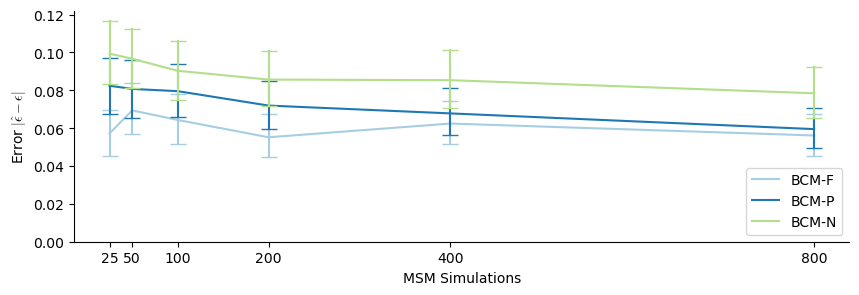

In [10]:
short_model_names = ["BCM-F", "BCM-P", "BCM-N"]

plt.rcParams["mathtext.fontset"] = "cm"
fig, axes = plt.subplots(ncols = 1, nrows = 1, figsize = (10, 3))

sns.lineplot(data = msm_tuning, x = "calibration_batches", 
             hue = "simulator_name", y =  "distance_epsilon", 
             palette = "Paired", err_style = "bars",
             err_kws = {"capsize": 6})

axes.set_ylim(0, 0.122)

cols, _ = axes.get_legend_handles_labels()
#axes.legend(cols, model_names, loc = "lower right")
axes.legend(cols, short_model_names, loc = "lower right")
axes.set_ylabel(r"Error $\vert \hat{\epsilon} - \epsilon \vert$")
axes.set_xlabel("MSM Simulations")
    
axes.set_xticks([25, 50, 100, 200, 400, 800])

sns.despine()

#fig.savefig("../paper/fig/tuning_msm_230809.pdf", format = "pdf", bbox_inches = "tight")
#fig.savefig("../paper/fig/tuning_msm_230809.png", format = "png", bbox_inches = "tight")